# Importing and inspecting data

In [4]:
# Importing + cleaning data:

import pandas as pd 
import numpy as np
import regex
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
import time
import datetime

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

# Import data:
df = pd.read_csv("/Users/paulinecuperus/Downloads/Gym_Data_Kaggle.csv")
#print(df.head())

# Check missing data:
print(df.isnull().sum())
# No missing data

# Check data + data formats:
print(df.info())
print(df.describe())

number_people           0
date                    0
timestamp               0
day_of_week             0
is_weekend              0
is_holiday              0
temperature             0
is_start_of_semester    0
is_during_semester      0
month                   0
hour                    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62184 entries, 0 to 62183
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   number_people         62184 non-null  int64  
 1   date                  62184 non-null  object 
 2   timestamp             62184 non-null  int64  
 3   day_of_week           62184 non-null  int64  
 4   is_weekend            62184 non-null  int64  
 5   is_holiday            62184 non-null  int64  
 6   temperature           62184 non-null  float64
 7   is_start_of_semester  62184 non-null  int64  
 8   is_during_semester    62184 non-null  int64  
 9   month                 6218

# Feature engineering:

In [5]:
# 1) day_of_week, is_weekend, is_holiday, is_start_of_semester, is_during_semester, month, and hour are all saved 
# as "Int64" but should be treated as categorical variables:
columns_to_be_transformed = ["day_of_week", "is_weekend", "is_holiday", "is_start_of_semester", "is_during_semester", "month", "hour"]

for column in columns_to_be_transformed:
    df[column] = df[column].astype("category")

In [6]:
# 2) Convert temperature from Fahrenheit to Celsius:
df["temperature"] = df.apply(lambda x: ((x["temperature"] - 32) * 5) / 9, axis = 1)

In [7]:
# 3) Extract part of the "date" string (YYYY-MM-DD) as separate column and change to DD-MM-YYYY
df["date_DMY"] = df["date"].str.replace("[\s][\S]*", "", regex = True)
df["date_DMY"] = df.apply(lambda x: datetime.datetime.strptime(x["date_DMY"], "%Y-%m-%d").strftime("%d/%m/%Y"), axis = 1)

In [8]:
# 4) Create column that shows the week number:
df["week_number"] = df.apply(lambda x: datetime.datetime.strptime(x["date_DMY"], "%d/%m/%Y").strftime("%V"), axis = 1)
# Coded as object data type, which is fine.

In [9]:
# 5) The "number_people" column shows the number of people in the gym at a given time point. As there are several time
# points per hour (roughly one every ten minutes), this makes it difficult to calculate the exact number of people 
# that were at the gym during a certain hour (people are likely counted more than once as most people will be.
# at the gym for >10 minutes.
# I will deal with this by reshaping the data so that each HOUR in a DAY is only present in one row (ergo summarising 
# the >1 time points per hour, with the number of visitors calculated as the mean of "number_people" of all time 
# points in that particular hour. Similarly, this new dataframe will have "temperature" as the mean temperature of
# all time points for that particular hour. This is not ideal, but gives an approximation of the number of people
# that were present in a particular hour, represented in a single row.

# Create new column that is day + hour:
df["date"] = df["date"].str.replace("[-][\d][\d][:][\d][\d]", "", regex = True)
df["day_hour"] = df.apply(lambda x: datetime.datetime.strptime(x["date"], "%Y-%m-%d %H:%M:%S").strftime("%d/%m/%Y-%H"), axis = 1)

# Get mean number of people and mean temperature by hour:
df_mean_people_temp = df.groupby(["day_hour"])[["number_people", "temperature"]].mean().reset_index()
print(len(df_mean_people_temp))

# Merge with original dataframe & drop duplicates:
df = pd.merge(df[["day_hour", "week_number", "day_of_week", "hour", "is_weekend", "is_holiday", "is_start_of_semester", "is_during_semester"]], df_mean_people_temp, on = "day_hour", how = "right")
df = df.drop_duplicates()

11637


# Exploratory data analysis:

/Users/paulinecuperus/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 9.444444444444438, 'Number of hourly visitors')

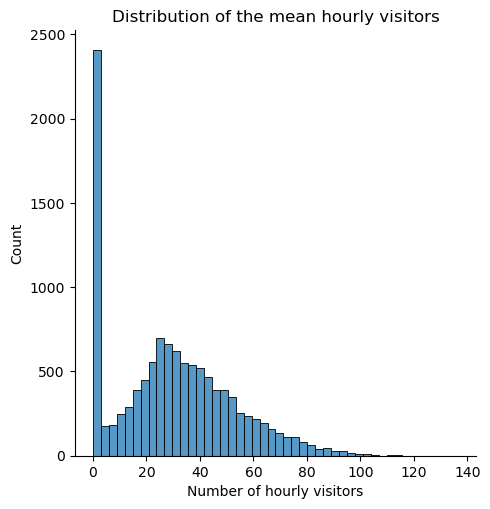

In [10]:
# Explore number_people:
sns.displot(df, x = "number_people")
plt.title("Distribution of the mean hourly visitors")
plt.xlabel("Number of hourly visitors")
# Note that 0 is the most frequent value by far.

/Users/paulinecuperus/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 12.44444444444443, 'Temperature (Celsius)')

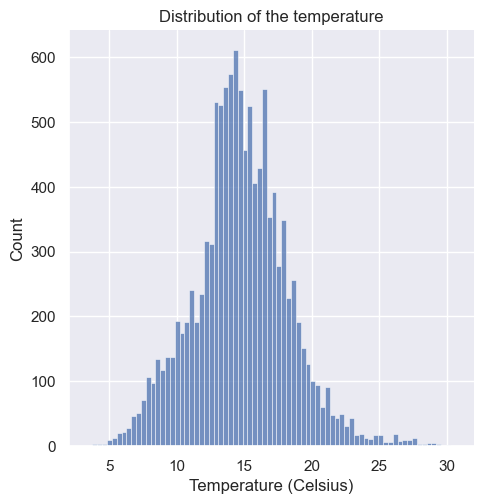

In [210]:
# Explore temperature:
sns.displot(df, x = "temperature")
plt.title("Distribution of the temperature")
plt.xlabel("Temperature (Celsius)")
# Normally distributed

Text(0.5, 1.0, 'Relation between temperature and mean number of hourly visitors')

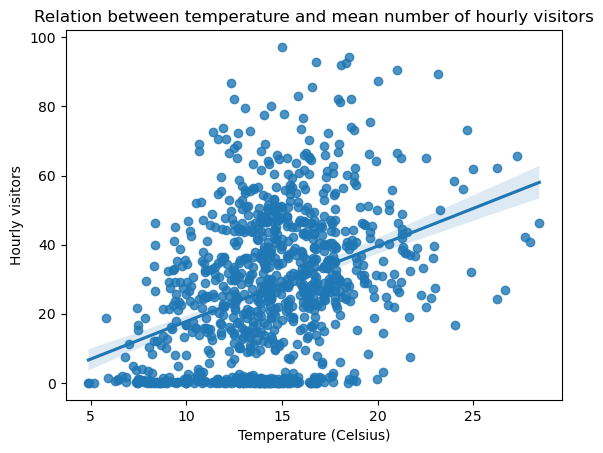

In [2]:
# Explore relationship between temperature and number of visitors:
# I will plot a subsample as there are too many points otherwise (risk of overplotting)

data_subset = df.sample(n = 1000)
sns.regplot(data = data_subset, x = "temperature", y = "number_people")
plt.xlabel("Temperature (Celsius)")
plt.ylabel("Hourly visitors")
plt.title("Relation between temperature and mean number of hourly visitors")

# There does appear to be positive moderate correlation here. However, this may be due to:
# 1) There being many "0" values for number_of_visitors, which are mainly located at the lower temperatures, 
# which I think may be due to:
# 2) There are more observations for lower temperatures.

# I don't think, however, that these are reasons to exclude this variable from any models later on. I think the "0"
# values at the lower temperature spectrum may well be explained to the time in the day (after all, it is colder at
# night and there will be more "0" values at night), which will be captured in the model by other variables.

In [212]:
# Explore day of week:
print(df["day_of_week"].value_counts())

# It looks like we do not quite have the same number of observations for each day of the week. This ranges from
# 1635 (Friday) to 1698 (Tuesday).
# Check whether this could be because of different opening hours on days:
daily_opening_hours = df.groupby("day_of_week")["hour"].unique().reset_index()
print([len(x) for x in daily_opening_hours["hour"]])

# All hours are present for each day. I will assume some data are missing at random.

day_of_week
1    1698
2    1689
3    1677
0    1660
4    1641
5    1637
6    1635
Name: count, dtype: int64
[24, 24, 24, 24, 24, 24, 24]


8365
3272


Text(0, 0.5, 'Visitors')

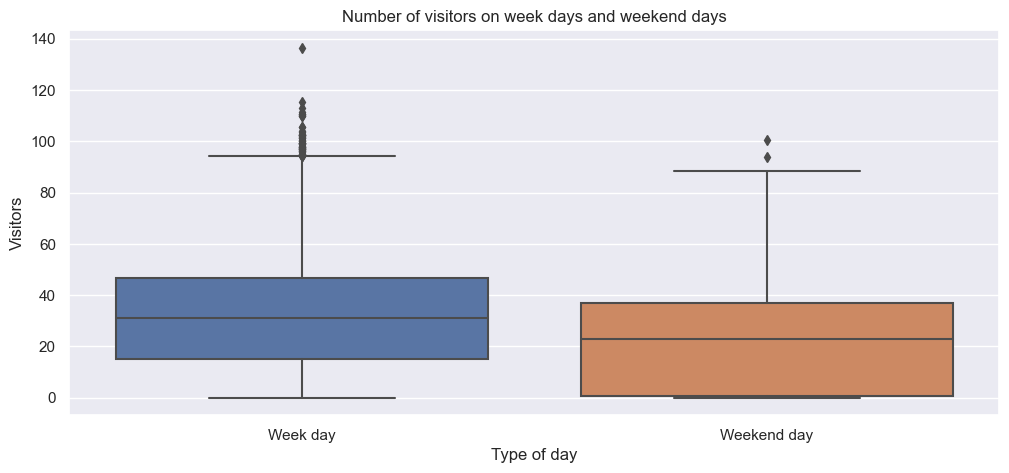

In [213]:
# Explore is_weekend   
print(len(df[df["is_weekend"] == 0]))
print(len(df[df["is_weekend"] == 1]))

ax = sns.boxplot(data = df, x = "is_weekend", y = "number_people")
ax.set_xticklabels(["Week day", "Weekend day"])
plt.title("Mean of hourly visitors on week days and weekend days")
plt.xlabel("Type of day")
plt.ylabel("Visitors")
# Some outliers here.

11610
27


Text(0, 0.5, 'Visitors')

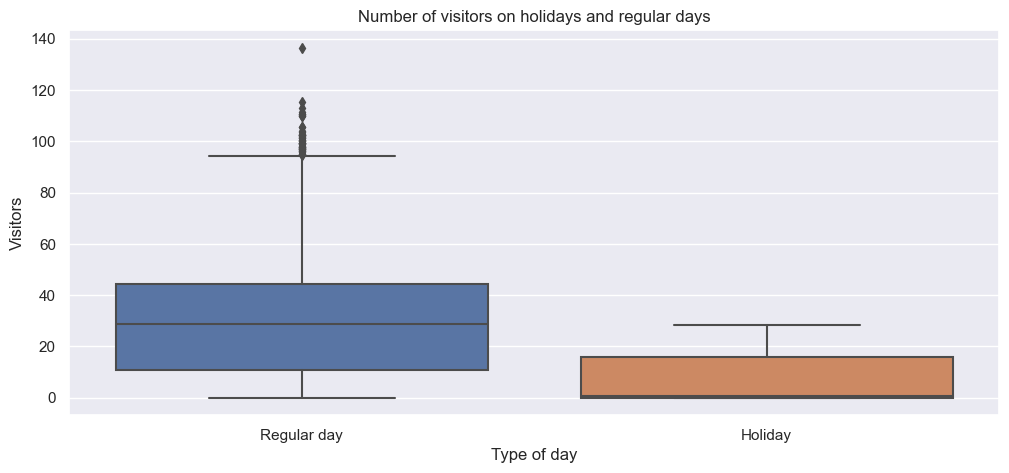

In [214]:
# Explore is_holiday
print(len(df[df["is_holiday"] == 0]))
print(len(df[df["is_holiday"] == 1]))

ax = sns.boxplot(data = df, x = "is_holiday", y = "number_people")
ax.set_xticklabels(["Regular day", "Holiday"])
plt.title("Number of visitors on holidays and regular days")
plt.xlabel("Type of day")
plt.ylabel("Hourly visitors")

# There are only 27 observations that were on holidays, compared to 11610 observations that were on regular days.
# This is very unbalanced and I will therefore not use this feature for any further analysis.

10673
964


Text(0, 0.5, 'Hourly visitors')

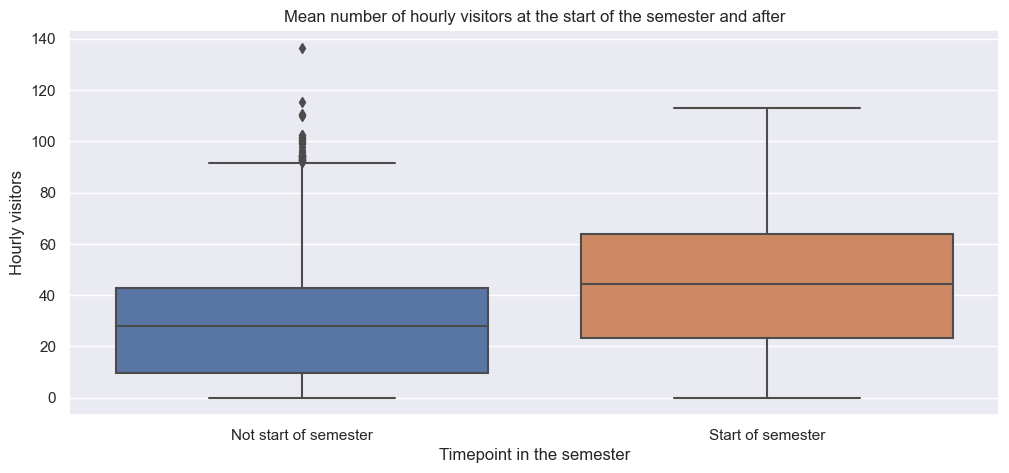

In [218]:
# is_start_of_semester 
print(len(df[df["is_start_of_semester"] == 0]))
print(len(df[df["is_start_of_semester"] == 1]))

ax = sns.boxplot(data = df, x = "is_start_of_semester", y = "number_people")
ax.set_xticklabels(["Not start of semester", "Start of semester"])
plt.title("Mean number of hourly visitors at the start of the semester and after")
plt.xlabel("Timepoint in the semester")
plt.ylabel("Hourly visitors")

# Relatively unbalanced classes in this feature too (10673 versus 964)

3697
7940


Text(0, 0.5, 'Visitors')

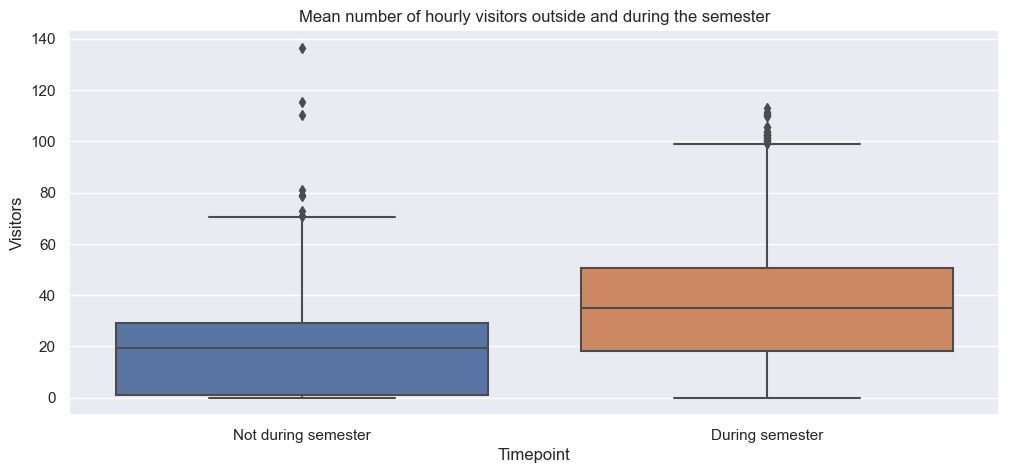

In [219]:
# is_start_of_semester 
print(len(df[df["is_during_semester"] == 0]))
print(len(df[df["is_during_semester"] == 1]))

ax = sns.boxplot(data = df, x = "is_during_semester", y = "number_people")
ax.set_xticklabels(["Not during semester", "During semester"])
plt.title("Mean number of hourly visitors outside and during the semester")
plt.xlabel("Timepoint")
plt.ylabel("Visitors")

In [222]:
# I'm wondering whether the "week_number" feature already carries the information that is in "is_start_of_semester"
# and "not_during_semester".
frequency_count = df.groupby(["week_number", "is_during_semester", "is_start_of_semester"]).size().reset_index(name = "frequency")
print(frequency_count.to_string())

# While there is some variability given that there is data from three different years, I think "week_number" 
# captures the information sufficiently. I will therefore use this as a feature instead
# of "is_start_of_semester" and "not_during_semester". This will also solve the issue of unbalanced classes for
# "is_start_of_semester".


    week_number is_during_semester is_start_of_semester  frequency
0            01                  0                    0        229
1            01                  0                    1          0
2            01                  1                    0          0
3            01                  1                    1          0
4            02                  0                    0        121
5            02                  0                    1          0
6            02                  1                    0          0
7            02                  1                    1         21
8            03                  0                    0          3
9            03                  0                    1          0
10           03                  1                    0          0
11           03                  1                    1        212
12           04                  0                    0          0
13           04                  0                    1       

/Users/paulinecuperus/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 12.44444444444443, 'Time')

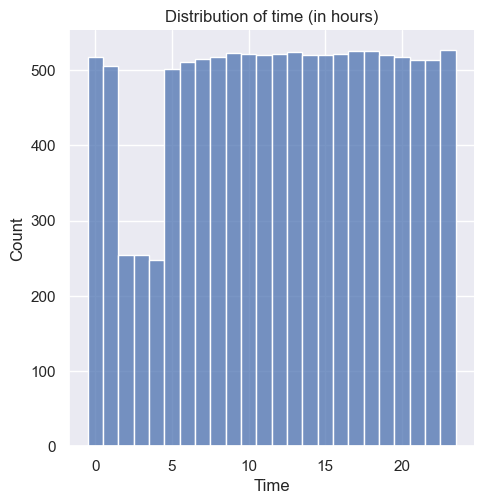

In [223]:
# Time:
ax = sns.displot(df, x = "hour")
plt.title("Distribution of time (in hours)")
plt.xlabel("Time")
# Note: Fewer observations for 1-5.

# Q1: What are the most/least popular weeks to visit the gym throughout the year? 

Text(0.5, 1.0, 'Weekly gym visitor numbers')

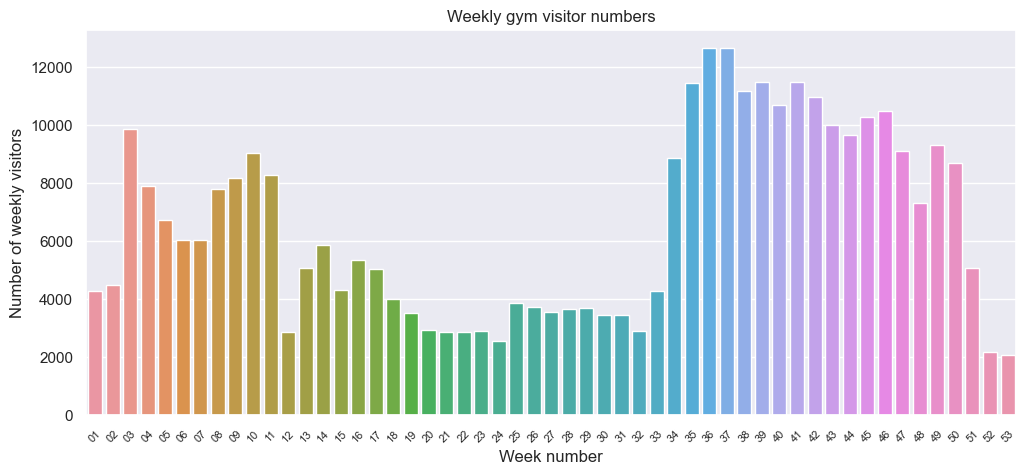

In [245]:
# Group data by week number:
visitors_by_week = df.groupby(["week_number"])["number_people"].sum().reset_index()

# Visualise data:
sns.barplot(data = visitors_by_week, x = "week_number", y = "number_people")
sns.set(rc = {"figure.figsize" : (12, 5)})
plt.xticks(rotation = 45, fontsize = 8)
plt.xlabel("Week number")
plt.ylabel("Number of weekly visitors")
plt.title("Weekly gym visitor numbers")

# Q2: What are the most/least popular times to visit the gym throughout each day?

Index(['day_of_week', 'hour', 'number_people'], dtype='object')


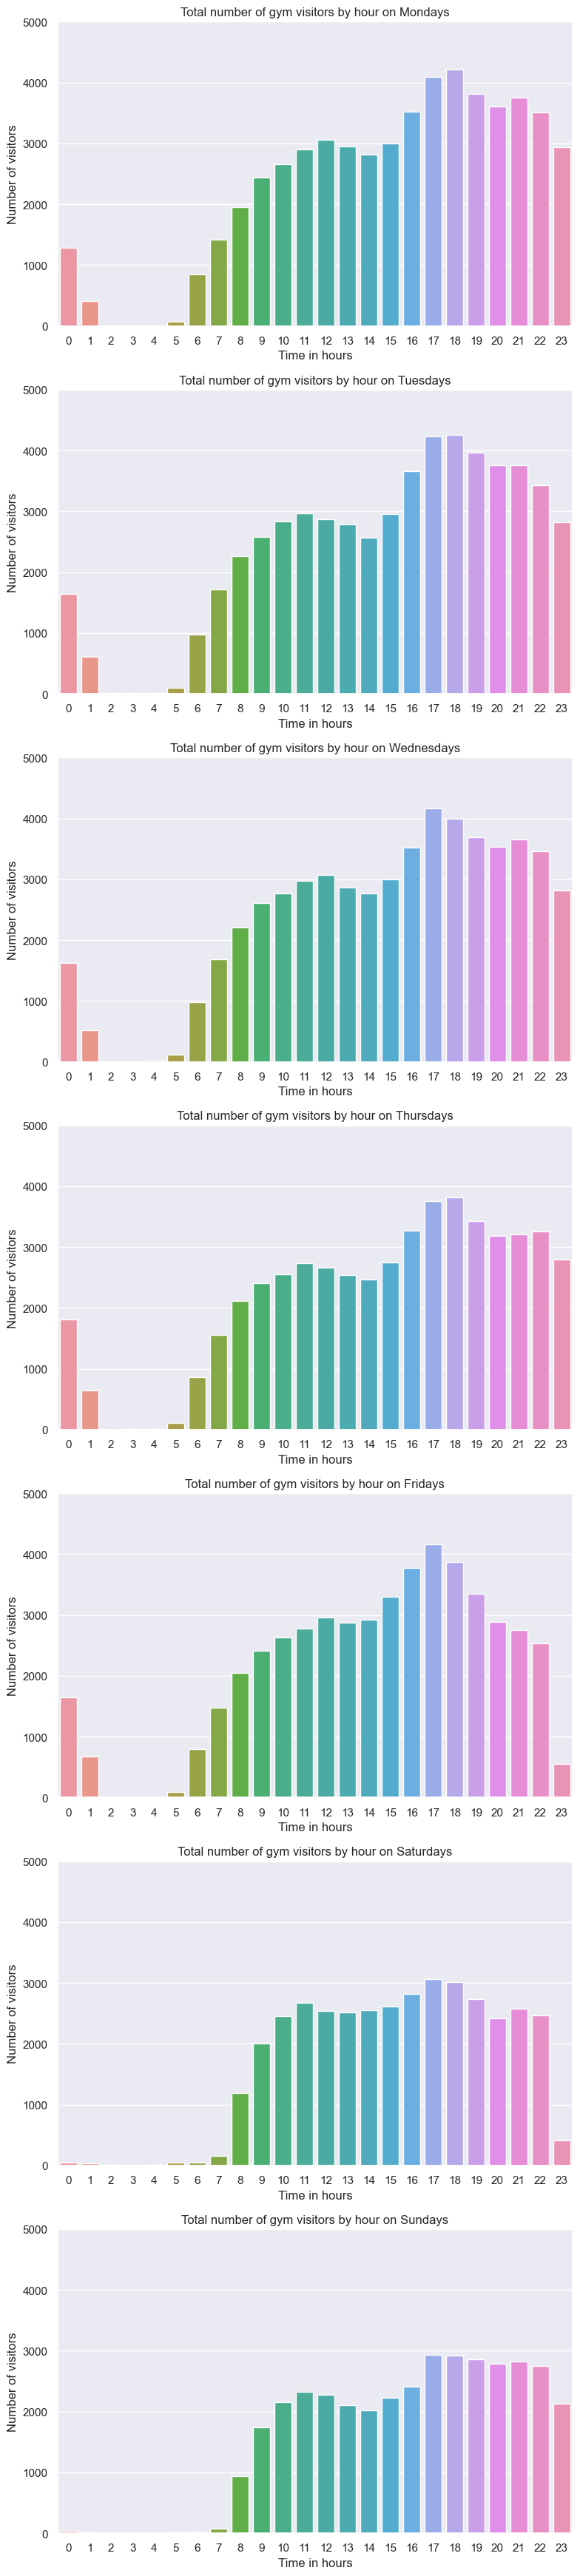

In [226]:
# Group data by time of the day:
visitors_by_hour_each_day = df.groupby(["day_of_week","hour"])["number_people"].sum().reset_index()
print(visitors_by_hour_each_day.columns)

# Visualise this per day:
fig, axs = plt.subplots(7, figsize = (8, 35))

# Create library to convert number to day of week:
number_to_day_library = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"}

for i in visitors_by_hour_each_day["day_of_week"].unique():
    df_day = visitors_by_hour_each_day[visitors_by_hour_each_day["day_of_week"] == i]
    sns.barplot(data = df_day, x = "hour", y = "number_people", ax = axs[i])
    axs[i].set_xlabel("Time in hours")
    axs[i].set_ylabel("Number of visitors")
    axs[i].set_ylim([0, 5000])
    axs[i].set_title("Total number of gym visitors by hour on {day}s".format(day = number_to_day_library[i]))
    
plt.tight_layout()
plt.show()


# Q3) Given the day of the week, the week number, the time, and the temperature, can we predict how many people will be visiting the gym?

### Random Forest Regressor

In [230]:
# Split into features + target variable:
X = df[["day_of_week", "week_number", "hour", "temperature"]]
y = df["number_people"]

# Split data into training and test sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)

# Initialise and train random forest classifier:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

# Evaluate the model:
y_pred = rfr.predict(X_test)
r_squared = r2_score(y_test, y_pred)

print(r_squared)
# R-squared = .79. This isn't great but may be sufficient for these purposes. Try to see whether KNN is better.

         day_hour week_number day_of_week hour is_weekend is_holiday  \
0   01/01/2016-00          53           4    0          0          0   
5   01/01/2016-01          53           4    1          0          0   
6   01/01/2016-05          53           4    5          0          0   
10  01/01/2016-06          53           4    6          0          0   
15  01/01/2016-07          53           4    7          0          0   
20  01/01/2016-08          53           4    8          0          0   
25  01/01/2016-09          53           4    9          0          0   
30  01/01/2016-10          53           4   10          0          0   
35  01/01/2016-11          53           4   11          0          0   
40  01/01/2016-12          53           4   12          0          0   

   is_start_of_semester is_during_semester  number_people  temperature  
0                     0                  0            0.2     6.855556  
5                     0                  0            1.0    

### K-Nearest Neighbours Regressor

In [11]:
# Split into features + target variable:
X = df[["day_of_week", "week_number", "hour", "temperature"]]
y = df["number_people"]

# Scale numeric data:
standard_scaler = StandardScaler()
X["temperature"] = standard_scaler.fit_transform(X["temperature"].values.reshape(-1, 1))

# Split data into training and test sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 42)

# Create and fit model (randomly chosen n_neighbors):
knnr = KNeighborsRegressor(n_neighbors = 3)
knnr.fit(X_train, y_train)

# Evaluate model:
y_pred = knnr.predict(X_test)
r_squared = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(r_squared)
print(mse)

# Worse performance than RF regressor. Perhaps this can be improved by tuning n_neighbors?

0.7386586924704468
132.88978313674968


/var/folders/8h/xdqqh6m15cj7tyl898mhpcr80000gn/T/ipykernel_28063/3076426714.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["temperature"] = standard_scaler.fit_transform(X["temperature"].values.reshape(-1, 1))


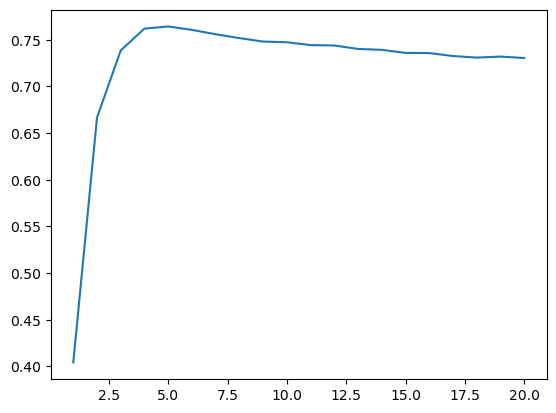

5
0.764288934230846
119.85702799567137


In [12]:
# Find optimal value for n_neighbours:
# Create list of n-options 1-20
n_neighbors_options = np.arange(1, 21)

# Create empty list for saving r-squared:
r_squared_list = []

# Run + evaluate model for each possible n_neighbour option:
for i in n_neighbors_options:
    knnr = KNeighborsRegressor(n_neighbors = i)
    knnr.fit(X_train, y_train)
    y_pred = knnr.predict(X_test)
    r_squared = r2_score(y_test, y_pred)
    r_squared_list.append(r_squared)

# Plot r-squared value per possible n_neighbours:
plt.plot(np.arange(1, 21), r_squared_list)
plt.show()

# It looks like 3 is not the best value for n_neighbors. Find best n:
best_n_neighbors = n_neighbors_options[np.argmax(r_squared_list)]
print(best_n_neighbors)
# 5

# Re-run model with best n_neighbors:
# Create and fit model:
knnr = KNeighborsRegressor(n_neighbors = 5)
knnr.fit(X_train, y_train)

# Get predictions on test set:
y_pred = knnr.predict(X_test)

# Evaluate model:
r_squared = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(r_squared)
print(mse)
# r squared has gone up to .764 and MSE down to 119.86. This is not better than the random forest regressor.